In [1]:
# Zachary Katz
# zachary_katz@mines.edu
# 27 May 2025

"""
Example harmonic analysis 
"""

# Extensions
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from utide import solve
import pandas as pd

import earthaccess
from pathlib import Path
import h5py
from astropy.time import Time
import Tides.Tides as Tides
import datetime
import seaborn as sns

/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Satellite repeat times [hr]
HR_IN_DAY = 24
SEC_IN_HR = 3600
T_icesat2 = 90.8193 * HR_IN_DAY  # 90.8193 days in hrs (From ATL03 POD ATBD)
T_swot = 20.86455 * HR_IN_DAY  # 21 days in hrs
T_cryosat_subcycle = 28.941 * HR_IN_DAY  # 28 days in hrs
T_jason = 9.9156 * HR_IN_DAY  # 9 days in hrs

# Tidal constituents [hr]
M2 = 12.4206012
S2 = 12
N2 = 12.65834751
K2 = 11.96723606

K1 = 23.9344721
O1 = 25.81933871
P1 = 24.06588766
Q1 = 26.868350

constituents = {
    "M2": M2,
    "S2": S2,
    "N2": N2,
    "K2": K2,
    "K1": K1,
    "O1": O1,
    "P1": P1,
    "Q1": Q1,
}

In [3]:
def tide_model(t, periods, parameters):
    """
    Generate the tide from synthetic data.

    Parameters
    ----------
    t : List
        List of sampling times in hours
    periods : dict
        Dictionary of tidal constituent periods in hours
    parameters : list
        List in form [A1, A2, ... , phi_1, phi_2, ...]
        where A is the amplitude in m and phi is the phase shift in radians

    Returns
    -------
    modeled : list
        Tides at time t as estimated by the model
    """
    assert len(parameters) == 2 * len(
        periods
    ), "Parameters must be twice the number of periods"

    model = np.zeros_like(t, dtype=float)
    n = len(periods)
    for i in range(n):
        A = parameters[i]
        phi = parameters[i + n]
        model += A * np.cos(2 * np.pi * t / periods[i] - phi)
    return model


def residuals(parameters, t, data, periods):
    """
    Residual function for scipy's least_squares
    Scipy does the squaring for us.
    """
    return tide_model(t, periods, parameters) - data

True: 1.000, Fitted: 1.007
True: 2.000, Fitted: 2.010
True: 0.300, Fitted: 0.329
True: 2.000, Fitted: 1.992
True: 1.000, Fitted: 1.026
True: 2.000, Fitted: 2.019
True: 0.000, Fitted: 0.013
True: 1.000, Fitted: 1.013
True: 0.000, Fitted: -0.035
True: 0.000, Fitted: 0.005
True: 0.000, Fitted: 0.089
True: 0.000, Fitted: -0.009
True: 1.571, Fitted: 7.844
True: 0.393, Fitted: 0.384
True: 0.000, Fitted: 1.346
True: 0.785, Fitted: 0.778


Text(0, 0.5, 'Tide [m]')

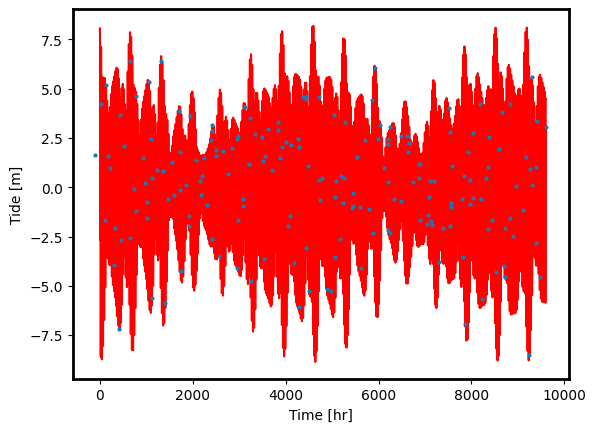

In [4]:
step = T_swot // 10  # hrs
t = np.arange(0, 400 * 24, step)
t = t + np.random.normal(0, 100, len(t))  # Nonuniform sampling
periods = [constituents[c] for c in constituents]
true_values = [1, 2, 0.3, 2, 1, 2, 0, 1, 0, 0, 0, 0, np.pi / 2, np.pi / 8, 0, np.pi / 4]

synthetic_data = tide_model(t, periods, true_values) + np.random.normal(0, 0.2, len(t))

initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fit = least_squares(residuals, initial_guess, args=(t, synthetic_data, periods))

# Print real and fitted parameters
for true, fitted in zip(true_values, fit.x):
    print(f"True: {true:.3f}, Fitted: {fitted:.3f}")

fig, ax = plt.subplots()
ax.scatter(t, synthetic_data, s=4)
fit_times = np.arange(0, 400 * 24, 0.1)
fit_tide = tide_model(fit_times, periods, fit.x)
ax.plot(fit_times, fit_tide, color="red", zorder=0)
ax.set_xlabel("Time [hr]")
ax.set_ylabel("Tide [m]")

In [5]:
t_as_time = pd.date_range(start="2020-01-02T08:50:00", periods=len(t), freq=f"{step}h")
# Utide analysis
soln = solve(t_as_time, synthetic_data, lat=-84.2986, method="ols", conf_int="linear")
for i, constitutent in enumerate(soln.name):
    print(
        f"Constitutent: {constitutent}, Amplitude: {soln.A[i]}, A_ci: {soln.A_ci[i]} Phase: {soln.g[i]*np.pi/180}, g_ci: {soln.g_ci[i]}"
    )

solve: matrix prep ... solution ... done.
Constitutent: BET1, Amplitude: 94485354365.79231, A_ci: nan Phase: 4.829346946883337, g_ci: nan
Constitutent: 2MN6, Amplitude: 52286371187.36996, A_ci: nan Phase: 0.9962606872961901, g_ci: nan
Constitutent: SA, Amplitude: 8497489030.663922, A_ci: 5.999975608411002e-05 Phase: 1.4502187620603757, g_ci: 1.4920650241771751e-13
Constitutent: SSA, Amplitude: 3214774043.057203, A_ci: nan Phase: 4.792287904654554, g_ci: nan
Constitutent: CHI1, Amplitude: 1885877507.8022482, A_ci: nan Phase: 0.5642329337572344, g_ci: nan
Constitutent: NO1, Amplitude: 1602663759.321233, A_ci: nan Phase: 4.1571155492237075, g_ci: nan
Constitutent: MKS2, Amplitude: 1458022903.9844115, A_ci: nan Phase: 0.7841906254685334, g_ci: nan
Constitutent: M3, Amplitude: 1292909026.278681, A_ci: nan Phase: 5.414346495996364, g_ci: nan
Constitutent: MN4, Amplitude: 1086055782.1602669, A_ci: nan Phase: 4.692856931844808, g_ci: nan
Constitutent: L2, Amplitude: 874038723.9510086, A_ci: na

In [6]:
# Try with IceSat-2 crossover at gz05
# User-defined path
data_path = "../data/ATL11/"

# Download ATL11 if necessary
results = earthaccess.search_data(
    short_name="ATL11",
    granule_name="ATL11_134011_0326_006_12.h5",
)
print(results)
earthaccess.download(results, data_path, provider="POCLOUD")
files = list(Path(data_path).glob("*.h5"))

[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3B Slope-Corrected Land Ice Height Time Series V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -153.59526, 'Latitude': -78.98162}, {'Longitude': -153.87878, 'Latitude': -78.9677}, {'Longitude': -153.99141, 'Latitude': -78.98917}, {'Longitude': -155.48991, 'Latitude': -80.24384}, {'Longitude': -160.10742, 'Latitude': -82.8004}, {'Longitude': -164.22914, 'Latitude': -84.16105}, {'Longitude': 178.20076, 'Latitude': -86.664}, {'Longitude': 157.00415, 'Latitude': -87.60905}, {'Longitude': 88.84637, 'Latitude': -87.43669}, {'Longitude': 56.05837, 'Latitude': -84.17317}, {'Longitude': 49.46781, 'Latitude': -81.64929}, {'Longitude': 47.27274, 'Latitude': -80.24236}, {'Longitude': 45.77733, 'Latitude': -78.98982}, {'Longitude': 45.71627, 'Latitude': -78.97243}, {'Longitude': 45.60891, 'Latitude': -78.96835}, {'Longitude': 45.53695, 'Latitude': -78.97633}, {'Longitude': 45.24915, 

QUEUEING TASKS | : 100%|██████████| 2/2 [00:00<00:00, 1563.87it/s]
PROCESSING TASKS | : 100%|██████████| 2/2 [00:00<00:00, 13617.87it/s]
COLLECTING RESULTS | : 100%|██████████| 2/2 [00:00<00:00, 25115.59it/s]


In [7]:
# Print available groups from file 1
!h5dump -n {files[0]}

HDF5 "../data/ATL11/ATL11_134011_0326_006_12.h5" {
FILE_CONTENTS {
 group      /
 group      /METADATA
 group      /METADATA/AcquisitionInformation
 group      /METADATA/AcquisitionInformation/lidar
 group      /METADATA/AcquisitionInformation/lidarDocument
 group      /METADATA/AcquisitionInformation/platform
 group      /METADATA/AcquisitionInformation/platformDocument
 group      /METADATA/DataQuality
 group      /METADATA/DataQuality/CompletenessOmission
 group      /METADATA/DataQuality/DomainConsistency
 group      /METADATA/DatasetIdentification
 group      /METADATA/Extent
 group      /METADATA/Lineage
 group      /METADATA/Lineage/ANC36-11
 group      /METADATA/Lineage/ANC38-11
 group      /METADATA/Lineage/ATL06
 group      /METADATA/Lineage/Control
 group      /METADATA/ProcessStep
 group      /METADATA/ProcessStep/Browse
 group      /METADATA/ProcessStep/Metadata
 group      /METADATA/ProcessStep/PGE
 group      /METADATA/ProcessStep/QA
 group      /METADATA/ProductSpecific

In [8]:
for file in files[:7]:
    with h5py.File(file, "r") as fi:
        print(fi["/"])

<HDF5 group "/" (7 members)>


In [9]:
# Make array of ATL11 data
data_arr = []

# Each reference track pair is a group
group = ["/pt1/", "/pt2/", "/pt3/"]

# Loop over files
for file in files[:7]:
    # Loop over pairs
    for i, g in enumerate(group):
        data = {}
        # Load variables into dictionary list
        with h5py.File(file, "r") as fi:
            data["t_ref"] = fi["/ancillary_data/atlas_sdp_gps_epoch"][
                :
            ]  # ICESat-2 reference epoch
            data["filename"] = file
            data["group"] = g

            # Crossing track data
            data["x_q_flag"] = fi[g + "crossing_track_data/atl06_quality_summary"][
                :
            ]  # 0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
            data["x_lat"] = fi[g + "crossing_track_data/latitude"][
                :
            ]  # Latitude [degrees]
            data["x_lon"] = fi[g + "crossing_track_data/longitude"][
                :
            ]  # Longitude [degrees]
            data["x_h_corr"] = fi[g + "crossing_track_data/h_corr"][
                :
            ]  # Mean corrected height [m]
            data["x_t_dt"] = fi[g + "crossing_track_data/delta_time"][
                :
            ]  # GPS seconds since reference epoch
            data["x_cycle_number"] = fi[g + "crossing_track_data/cycle_number"][
                :
            ]  # Cycle
            data["x_rgt"] = fi[g + "crossing_track_data/rgt"][
                :
            ]  # Reference ground track
            data["x_spot_crossing"] = fi[g + "crossing_track_data/spot_crossing"][
                :
            ]  # Spot  number
            data["x_ref_pt"] = fi[g + "crossing_track_data/ref_pt"][
                :
            ]  # Reference point

            time_temp = data["t_ref"] + data["x_t_dt"]
            data["x_time"] = Time(
                time_temp, format="gps"
            ).iso  # Convert to readable time
            data["x_tide"] = fi[
                g + "crossing_track_data/tide_ocean"
            ]  # Not ocean_tide as in the ATBD
            data["x_ref_pt"] = fi[g + "crossing_track_data/ref_pt"][:]

            # Main track data
            data["lat"] = fi[g + "/latitude"][:]  # Latitude [degrees]
            data["lon"] = fi[g + "/longitude"][:]  # Longitude [degrees]
            data["h_corr"] = fi[g + "/h_corr"][:]  # Mean corrected height [m]
            data["t_dt"] = fi[g + "/delta_time"][:]  # GPS seconds since reference epoch
            data["q_flag"] = fi[g + "/quality_summary"][
                :
            ]  # 0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
            data["cycle_number"] = fi[g + "/cycle_number"][:]  # Cycle
            data["ref_pt"] = fi[g + "/ref_pt"][:]  # Reference point
            time_temp = data["t_ref"] + data["t_dt"]
            data["time"] = Time(time_temp, format="gps").iso  # Convert to readable time
            data["tide"] = fi[g + "/cycle_stats/tide_ocean"][:]  # Tide correction [m]

        data_arr.append(data)

/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.


In [10]:
np.unique(data_arr[0]["tide"])
data_arr[0]["tide"].shape
data_arr[0]["lat"].shape

(40581,)

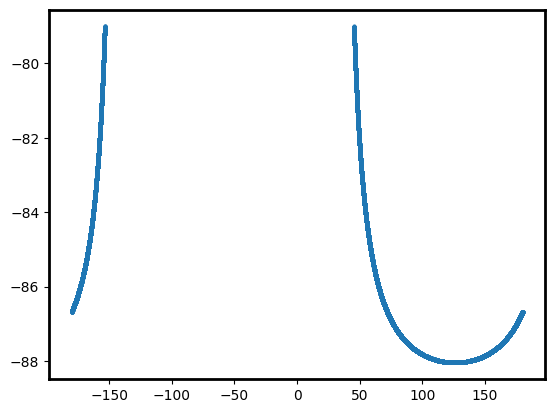

In [11]:
fig, ax = plt.subplots()
ax.scatter(data_arr[0]["lon"], data_arr[0]["lat"], s=4)

In [12]:
# Find closest point to gz05 for data_arr[0]
trk_X = data_arr[0]
gz05_lat, gz05_lon = -84.2986, -164.5206
gz05_lat, gz05_lon = -84.4986, -164.7206
lat_lon = np.column_stack((trk_X["x_lat"], trk_X["x_lon"]))
dists = np.linalg.norm(lat_lon - [gz05_lat, gz05_lon], axis=1)
min_index = np.argmin(dists)
print(lat_lon[min_index], dists[min_index], min_index)
ref_pt = trk_X["x_ref_pt"][min_index]

mskx = (trk_X["x_ref_pt"] == ref_pt) & (trk_X["x_t_dt"] < 2e300)
msk = trk_X["ref_pt"] == ref_pt
print(trk_X["x_rgt"][mskx])
mskd_lat = trk_X["lat"][msk]
mskd_lon = trk_X["lon"][msk]
mskd_xlat = trk_X["x_lat"][mskx]
mskd_xlon = trk_X["x_lon"][mskx]
mskd_xh = trk_X["x_h_corr"][mskx]
mskd_h = trk_X["h_corr"][msk]
msk_h = mskd_h < 1e30
mskd_h = mskd_h[msk_h]
mskd_xt = trk_X["x_time"][mskx]
mskd_xcycle = trk_X["x_cycle_number"][mskx]
mskd_xrgt = trk_X["x_rgt"][mskx]
mskd_xrefpt = trk_X["x_ref_pt"][mskx]
# mskd_xtide = trk_X["x_tide"][mskx]

mskd_t = trk_X["time"][msk]
mskd_tdt = trk_X["t_dt"][msk]
# mskd_refpt = trk_X["ref_pt"][msk_t]
# mskd_tide = trk_X["tide"][msk]
msk_t = mskd_tdt < 1e300
mskd_t = mskd_t[msk_t]
msk_t = msk_t.flatten()
mskd_cycle = trk_X["cycle_number"][msk_t]

mskd_lon = np.ones(len(mskd_t)) * mskd_lon
mskd_lat = np.ones(len(mskd_t)) * mskd_lat
mskd_rgt = np.ones(len(mskd_t), dtype=int) * int(files[0].stem.split("_")[1][:4])

print(mskd_h, mskd_xh)
print(
    len(mskd_lat),
    len(mskd_lon),
    len(mskd_t),
    len(mskd_cycle),
    len(mskd_rgt),
    len(mskd_h),
    # len(mskd_tide),
)
print(
    len(mskd_xlat),
    len(mskd_xlon),
    len(mskd_xt),
    len(mskd_xcycle),
    len(mskd_xrgt),
    len(mskd_xh),
    # len(mskd_xtide),
)
df1 = pd.DataFrame(
    {
        "lat": mskd_xlat,
        "lon": mskd_xlon,
        "time": mskd_xt,
        "cycle_number": mskd_xcycle,
        "rgt": mskd_xrgt,
        "h_corr": mskd_xh,
        # "tide": mskd_xtide,
    }
)
df2 = pd.DataFrame(
    {
        "lat": mskd_lat,
        "lon": mskd_lon,
        "time": mskd_t,
        "cycle_number": mskd_cycle,
        "rgt": mskd_rgt,
        "h_corr": mskd_h,
        # "tide": mskd_tide,
    }
)
df = pd.concat([df1, df2], ignore_index=True)
df = df.sort_values(by=["time"]).reset_index(drop=True)

df = [df[(df["h_corr"] < 80) & (df["h_corr"] > 30)]]
df = df[0]

# Remove mean from h_corr

df["h_corr_demeaned"] = df["h_corr"] - df["h_corr"].mean()

# Convert time to hours since first time
df["datetime"] = df["time"]
df["time"] = (
    pd.to_datetime(df["time"]) - pd.to_datetime(df["time"].iloc[0])
).dt.total_seconds() / SEC_IN_HR
df

[ -84.52880701 -164.71318608] 0.031103532052413826 47242
[694 694 694 694 694 694 694 694 694 694 694 694 694 694 694]
[60.569748 59.930233 59.299946 59.94663  59.415024 59.734016 59.0988
 59.33093  59.419304 59.403057 60.454235 59.42841  59.921215 59.85144
 58.488747] [59.91014  60.24794  60.562054 60.066574 61.01695  60.42775  59.886566
 60.37091  59.042072 59.483448 59.86183  58.482857 59.708843 59.066376
 59.546017]
15 15 15 15 15 15
15 15 15 15 15 15


,lat,lon,time,cycle_number,rgt,h_corr,h_corr_demeaned,datetime
0,-84.528807,-164.713186,0.000000,3,694,59.910141,0.177734,2019-05-13 17:55:02.540
1,-84.528807,-164.713186,4359.326888,5,694,60.247940,0.515533,2019-11-11 09:14:39.335
2,-84.528807,-164.713186,5374.467320,5,1340,60.569748,0.837341,2019-12-23 16:23:04.892
3,-84.528807,-164.713186,7554.129531,6,1340,59.930233,0.197826,2020-03-23 12:02:48.851
4,-84.528807,-164.713186,8718.652885,7,694,60.562054,0.829647,2020-05-11 00:34:12.927
5,-84.528807,-164.713186,10898.315294,8,694,60.066574,0.334167,2020-08-09 20:13:57.600
6,-84.528807,-164.713186,11913.456406,8,1340,59.299946,-0.432461,2020-09-21 03:22:25.601
7,-84.528807,-164.713186,13077.978710,9,694,61.016949,1.284542,2020-11-08 15:53:45.897
8,-84.528807,-164.713186,14093.120725,9,1340,59.946629,0.214222,2020-12-20 23:02:17.149
9,-84.528807,-164.713186,15257.644302,10,694,60.427750,0.695343,2021-02-07 11:33:42.028


True: 0.125, Fitted: 0.08534
True: 0.138, Fitted: 0.13881
True: 0.112, Fitted: 0.10502
True: 0.048, Fitted: 0.61873
True: 0.452, Fitted: 0.37687
True: 0.371, Fitted: 0.52017
True: 0.144, Fitted: 0.13987
True: 0.076, Fitted: 0.43578
True: 221.062, Fitted: 1.24735
True: 164.575, Fitted: 0.52781
True: 132.822, Fitted: 0.61841
True: 174.373, Fitted: 1.37186
True: 198.697, Fitted: 0.37074
True: 182.270, Fitted: 1.40926
True: 195.884, Fitted: 1.77899
True: 172.692, Fitted: 0.80408


Text(0, 0.5, 'Tide [m]')

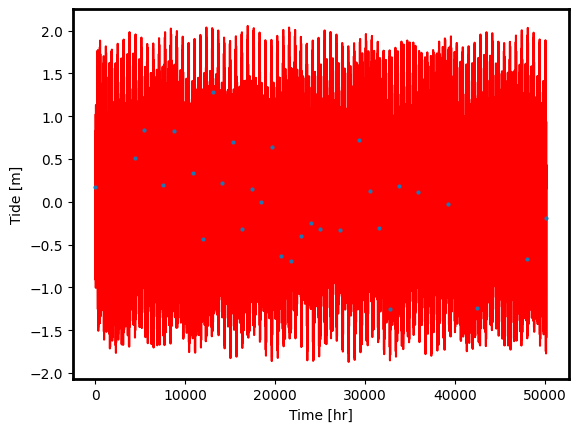

In [13]:
t = df["time"].values
data = df["h_corr_demeaned"].values
periods = [constituents[c] for c in constituents]

# From gz05 harmonic analysis
true_values = [
    0.125,
    0.138,
    0.112,
    0.048,
    0.452,
    0.371,
    0.144,
    0.076,
    221.062,
    164.575,
    132.822,
    174.373,
    198.697,
    182.270,
    195.884,
    172.692,
]
initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fit = least_squares(residuals, initial_guess, args=(t, data, periods))

IS2_MYHA = []
# Print real and fitted parameters
for true, fitted in zip(true_values, fit.x):
    fitted = np.abs(fitted)
    print(f"True: {true:.3f}, Fitted: {fitted:.5f}")
    IS2_MYHA.append(fitted)

fig, ax = plt.subplots()
ax.scatter(t, data, s=4)
fit_times = np.arange(0, df["time"].iloc[-1], 0.1)
fit_tide = tide_model(fit_times, periods, fit.x)
ax.plot(fit_times, fit_tide, color="red", zorder=0)
ax.set_xlabel("Time [hr]")
ax.set_ylabel("Tide [m]")

In [14]:
# Utide analysis
t = df["time"].values
data = df["h_corr"].values
soln_IS2_UTIDE = solve(t, data, lat=-84.2986, method="ols", conf_int="MC")
for i, constitutent in enumerate(soln.name):
    print(
        f"Constitutent: {constitutent}, Amplitude: {soln.A[i]}, A_ci: {soln.A_ci[i]} Phase: {soln.g[i]*np.pi/180}, g_ci: {soln.g_ci[i]}"
    )

solve: matrix prep ... solution ... done.
Constitutent: BET1, Amplitude: 94485354365.79231, A_ci: nan Phase: 4.829346946883337, g_ci: nan
Constitutent: 2MN6, Amplitude: 52286371187.36996, A_ci: nan Phase: 0.9962606872961901, g_ci: nan
Constitutent: SA, Amplitude: 8497489030.663922, A_ci: 5.999975608411002e-05 Phase: 1.4502187620603757, g_ci: 1.4920650241771751e-13
Constitutent: SSA, Amplitude: 3214774043.057203, A_ci: nan Phase: 4.792287904654554, g_ci: nan
Constitutent: CHI1, Amplitude: 1885877507.8022482, A_ci: nan Phase: 0.5642329337572344, g_ci: nan
Constitutent: NO1, Amplitude: 1602663759.321233, A_ci: nan Phase: 4.1571155492237075, g_ci: nan
Constitutent: MKS2, Amplitude: 1458022903.9844115, A_ci: nan Phase: 0.7841906254685334, g_ci: nan
Constitutent: M3, Amplitude: 1292909026.278681, A_ci: nan Phase: 5.414346495996364, g_ci: nan
Constitutent: MN4, Amplitude: 1086055782.1602669, A_ci: nan Phase: 4.692856931844808, g_ci: nan
Constitutent: L2, Amplitude: 874038723.9510086, A_ci: na

In [15]:
# Try with taking points from CATS
tide_dir = "/mnt/c/users/ZacharyKatz/Desktop/Research/Background"
tide_mod = "CATS2008-v2023"

tide_times = df["datetime"].values
tide_times = [datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S.%f") for t in tide_times]
gz05_lat = -84.2986
gz05_lon = -164.5206

tides = Tides.Tide(tide_mod, tide_dir)
tide_results = tides.tidal_elevation(
    [gz05_lon],
    [gz05_lat],
    tide_times,
).data.T[0]

['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']


True: 0.125, Fitted: 0.09030
True: 0.138, Fitted: 0.14890
True: 0.112, Fitted: 0.14587
True: 0.048, Fitted: 0.10186
True: 0.452, Fitted: 0.47633
True: 0.371, Fitted: 0.40550
True: 0.144, Fitted: 0.16017
True: 0.076, Fitted: 0.09896
True: 221.062, Fitted: 1.63482
True: 164.575, Fitted: 0.10882
True: 132.822, Fitted: 0.28169
True: 174.373, Fitted: 1.57716
True: 198.697, Fitted: 0.49311
True: 182.270, Fitted: 4.71256
True: 195.884, Fitted: 1.39084
True: 172.692, Fitted: 0.91667


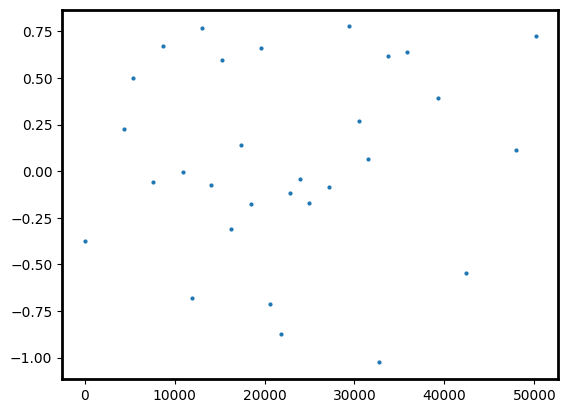

In [16]:
periods = [constituents[c] for c in constituents]
t = df["time"].values
data = tide_results / 100
# From gz05 harmonic analysis
true_values = [
    0.125,
    0.138,
    0.112,
    0.048,
    0.452,
    0.371,
    0.144,
    0.076,
    221.062,
    164.575,
    132.822,
    174.373,
    198.697,
    182.270,
    195.884,
    172.692,
]
initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fit = least_squares(residuals, initial_guess, args=(t, data, periods))

CATS_AT_IS2 = []
# Print real and fitted parameters
for true, fitted in zip(true_values, fit.x):
    fitted = np.abs(fitted)
    print(f"True: {true:.3f}, Fitted: {fitted:.5f}")
    CATS_AT_IS2.append(fitted)

fig, ax = plt.subplots()
ax.scatter(t, data, s=4)

In [17]:
import scipy
import matplotlib.dates as mdates

detrended = df["h_corr_demeaned"].values
detrended = scipy.signal.detrend(detrended)

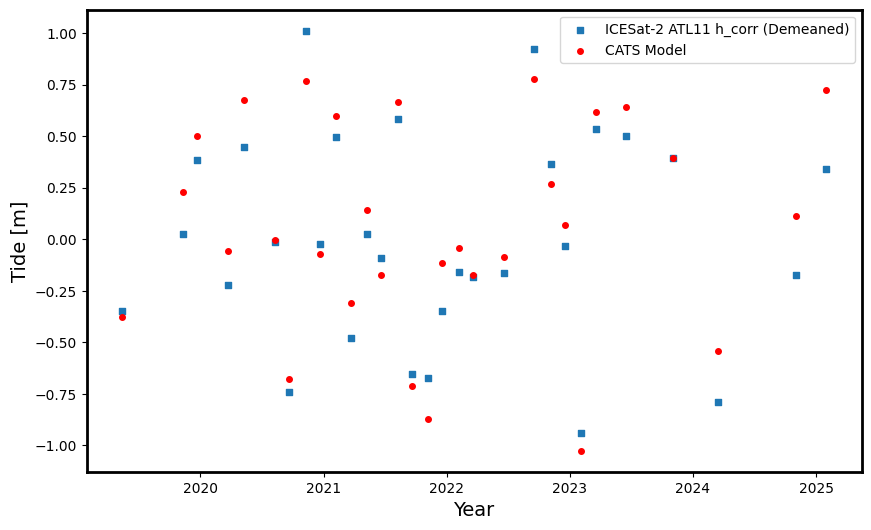

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(
    tide_times, detrended, s=16, label="ICESat-2 ATL11 h_corr (Demeaned)", marker="s"
)
ax.scatter(tide_times, tide_results / 100, s=16, color="red", label="CATS Model")
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Tide [m]", fontsize=14)
# Set x axis in years
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.legend()

In [ ]:
# See if we can get the correct answer by sampling more often.

# Hourly sampling between the first and last time
tide_times = pd.date_range(
    start=df["datetime"].iloc[0], end=df["datetime"].iloc[-1], freq="h"
)

gz05_lat = -84.2986
gz05_lon = -164.5206

tides = Tides.Tide(tide_mod, tide_dir)
tide_results = tides.tidal_elevation(
    [gz05_lon],
    [gz05_lat],
    tide_times,
).data.T[0]

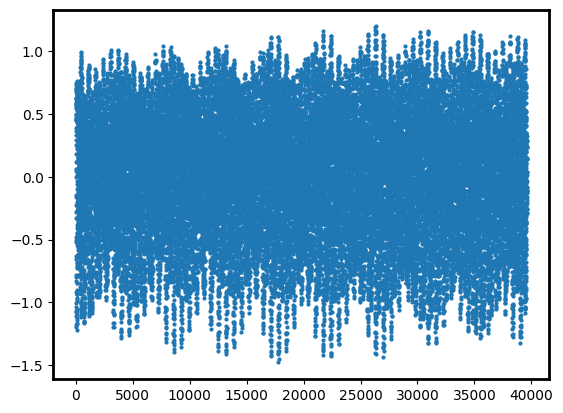

In [ ]:
# Convert tide_times to hours since first time
plot_times = (tide_times - tide_times[0]).total_seconds() / SEC_IN_HR

# Plot
fig, ax = plt.subplots()
ax.scatter(plot_times, tide_results / 100, s=4)

In [ ]:
# Utide analysis
soln_CATS_UTIDE = solve(
    tide_times, tide_results / 100, lat=-84.2986, method="ols", conf_int="MC"
)
for i, constitutent in enumerate(soln.name):
    print(
        f"Constitutent: {constitutent}, Amplitude: {soln.A[i]}, A_ci: {soln.A_ci[i]} Phase: {soln.g[i]*np.pi/180}, g_ci: {soln.g_ci[i]}"
    )

solve: matrix prep ... solution ... done.
Constitutent: MKS2, Amplitude: 2365112904.4306993, A_ci: nan Phase: 3.5093438565194814, g_ci: nan
Constitutent: 2MN6, Amplitude: 2016557768.6578276, A_ci: nan Phase: 4.653056028920921, g_ci: nan
Constitutent: SSA, Amplitude: 1985274810.4082348, A_ci: nan Phase: 5.613599149107627, g_ci: nan
Constitutent: CHI1, Amplitude: 1813439943.2294264, A_ci: nan Phase: 2.5780639124612796, g_ci: nan
Constitutent: MO3, Amplitude: 1804043429.2964256, A_ci: nan Phase: 5.40975486510543, g_ci: nan
Constitutent: BET1, Amplitude: 1798732674.147651, A_ci: nan Phase: 2.527533733319914, g_ci: nan
Constitutent: M2, Amplitude: 1648993312.2671406, A_ci: nan Phase: 6.019161410559904, g_ci: nan
Constitutent: M3, Amplitude: 1344585103.7911105, A_ci: nan Phase: 2.3220578701810632, g_ci: nan
Constitutent: NO1, Amplitude: 1322619843.3249705, A_ci: nan Phase: 5.180724039337977, g_ci: nan
Constitutent: H1, Amplitude: 1028837199.7410247, A_ci: nan Phase: 5.775436255225106, g_ci: 

In [18]:
tide_times

DatetimeIndex(['2019-12-23 16:23:03.852000', '2019-12-23 17:23:03.852000',
               '2019-12-23 18:23:03.852000', '2019-12-23 19:23:03.852000',
               '2019-12-23 20:23:03.852000', '2019-12-23 21:23:03.852000',
               '2019-12-23 22:23:03.852000', '2019-12-23 23:23:03.852000',
               '2019-12-24 00:23:03.852000', '2019-12-24 01:23:03.852000',
               ...
               '2024-06-29 14:23:03.852000', '2024-06-29 15:23:03.852000',
               '2024-06-29 16:23:03.852000', '2024-06-29 17:23:03.852000',
               '2024-06-29 18:23:03.852000', '2024-06-29 19:23:03.852000',
               '2024-06-29 20:23:03.852000', '2024-06-29 21:23:03.852000',
               '2024-06-29 22:23:03.852000', '2024-06-29 23:23:03.852000'],
              dtype='datetime64[ns]', length=39608, freq='h')

In [ ]:
periods = [constituents[c] for c in constituents]
data = tide_results / 100
# From gz05 harmonic analysis
true_values = [
    0.125,
    0.138,
    0.112,
    0.048,
    0.452,
    0.371,
    0.144,
    0.076,
    221.062,
    164.575,
    132.822,
    174.373,
    198.697,
    182.270,
    195.884,
    172.692,
]
initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
fit = least_squares(residuals, initial_guess, args=(plot_times, data, periods))


# Print real and fitted parameters
for true, fitted in zip(true_values, fit.x):
    fitted = np.abs(fitted)
    print(f"True: {true:.3f}, Fitted: {fitted:.5f}")

True: 0.125, Fitted: 0.12296
True: 0.138, Fitted: 0.14448
True: 0.112, Fitted: 0.13703
True: 0.048, Fitted: 0.07297
True: 0.452, Fitted: 0.47718
True: 0.371, Fitted: 0.39820
True: 0.144, Fitted: 0.15861
True: 0.076, Fitted: 0.08660
True: 221.062, Fitted: 0.31451
True: 164.575, Fitted: 0.50177
True: 132.822, Fitted: 0.29721
True: 174.373, Fitted: 0.91438
True: 198.697, Fitted: 0.74095
True: 182.270, Fitted: 0.71313
True: 195.884, Fitted: 0.82368
True: 172.692, Fitted: 10.99080


In [20]:
# load gz05 data and perform 2 harmonic analyses in UTIDE on SERAC:

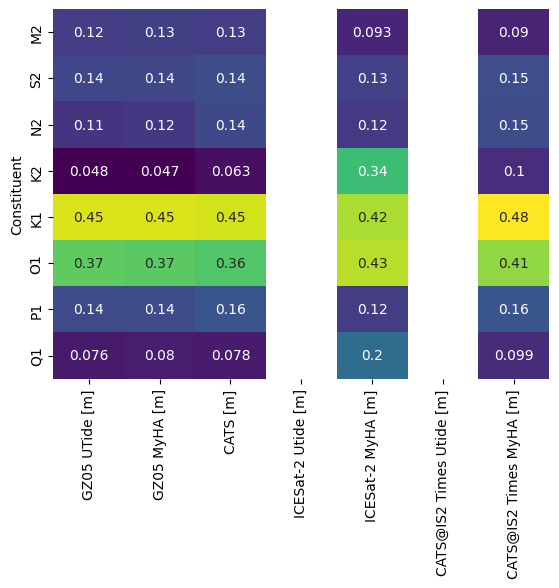

In [ ]:
# Summary Plot

# Table of constitutents colored by True - Estimated from my simple HA and python's UTide

df_plotting = pd.DataFrame(
    {
        "Constituent": list(constituents.keys()),
        "GZ05 UTide [m]": true_values[:8],
        "GZ05 MyHA [m]": [
            0.12663,
            0.13840,
            0.11655,
            0.04692,
            0.45270,
            0.36785,
            0.14390,
            0.08005,
        ],  # From UTide on SERAC
        "CATS [m]": [
            0.12530586123466492,
            0.14462734758853912,
            0.13967309892177582,
            0.06251237541437149,
            0.44746169447898865,
            0.35937005281448364,
            0.15769679844379425,
            0.07832222431898117,
        ],
        "ICESat-2 Utide [m]": [np.nan] * 8,
        "ICESat-2 MyHA [m]": IS2_MYHA[:8],
        "CATS@IS2 Times Utide [m]": [np.nan] * 8,
        "CATS@IS2 Times MyHA [m]": CATS_AT_IS2[:8],
    }
)

# Make plot
df_for_plot = df_plotting.set_index(df_plotting.columns[0])
plot = sns.heatmap(df_for_plot, annot=True, cmap="viridis", cbar=False)

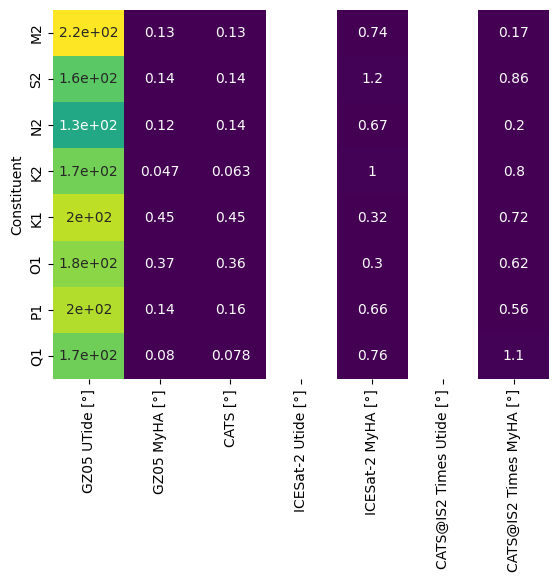

In [ ]:
# Summary Plot Phase

# Table of constitutents colored by True - Estimated from my simple HA and python's UTide

df_plotting = pd.DataFrame(
    {
        "Constituent": list(constituents.keys()),
        "GZ05 UTide [°]": true_values[8:],
        "GZ05 MyHA [°]": [
            0.12663,
            0.13840,
            0.11655,
            0.04692,
            0.45270,
            0.36785,
            0.14390,
            0.08005,
        ],  # From UTide on SERAC
        "CATS [°]": [
            0.12530586123466492,
            0.14462734758853912,
            0.13967309892177582,
            0.06251237541437149,
            0.44746169447898865,
            0.35937005281448364,
            0.15769679844379425,
            0.07832222431898117,
        ],
        "ICESat-2 Utide [°]": [np.nan] * 8,
        "ICESat-2 MyHA [°]": IS2_MYHA[8:],
        "CATS@IS2 Times Utide [°]": [np.nan] * 8,
        "CATS@IS2 Times MyHA [°]": CATS_AT_IS2[8:],
    }
)

# Make plot
df_for_plot = df_plotting.set_index(df_plotting.columns[0])
plot = sns.heatmap(df_for_plot, annot=True, cmap="viridis", cbar=False)